In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png
/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv


In [2]:
import pandas_profiling as pp

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

In [4]:
import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm

In [5]:
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [7]:
df = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

pp.ProfileReport(df)

In [8]:
df['reviews_per_month'].fillna(0, inplace = True)

In [9]:
df.drop(['id', 'name', 'last_review', 'host_name'], axis = 1, inplace = True)

As we can see the price is skewed,  so a log transformation and removing outlier should work for regrerssor algorithms

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


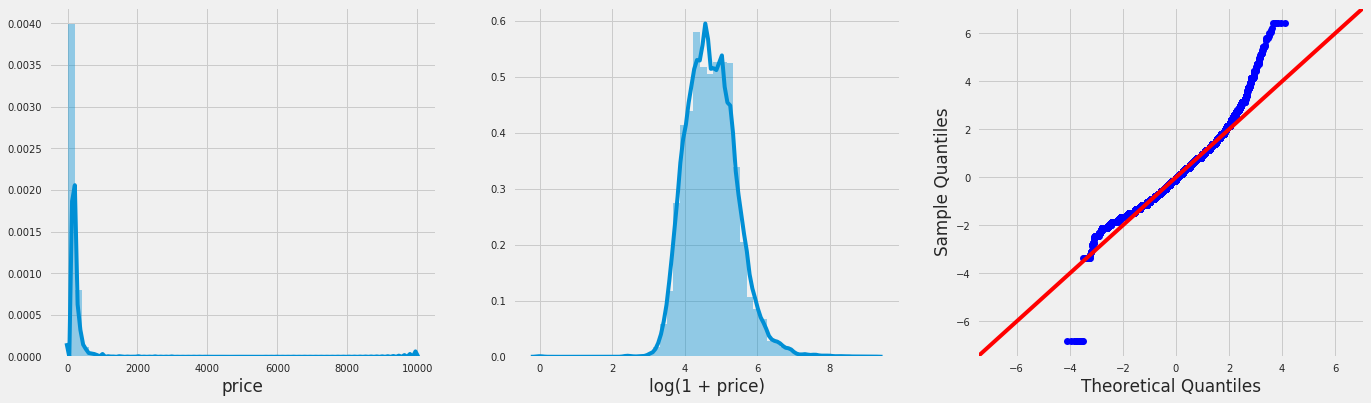

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (21,6))
sns.distplot(df['price'], ax = axes[0])
sns.distplot(np.log1p(df['price']), ax = axes[1])
axes[1].set_xlabel('log(1 + price)')
sm.qqplot(np.log1p(df['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [11]:
df = df[np.log1p(df['price']) < 7]
df = df[np.log1p(df['price']) > 3]

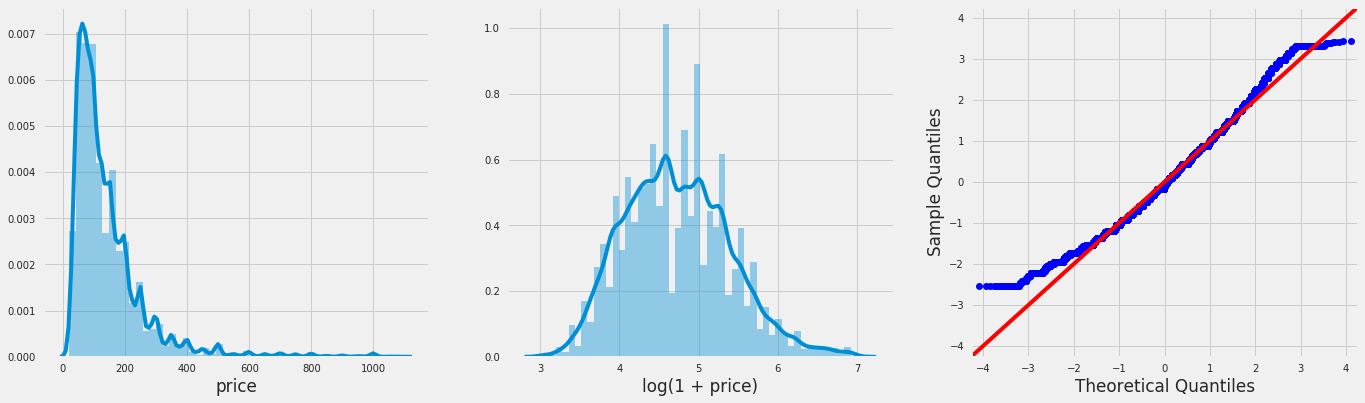

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (21,6))
sns.distplot(df['price'], ax = axes[0])
sns.distplot(np.log1p(df['price']), ax = axes[1])
axes[1].set_xlabel('log(1 + price)')
sm.qqplot(np.log1p(df['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [13]:
df['price'] = np.log1p(df['price'])

Highly skewed 'minimum_nights' should be fixed by taking log(1 + minimum_nights) 

Text(0, 0.5, 'count')

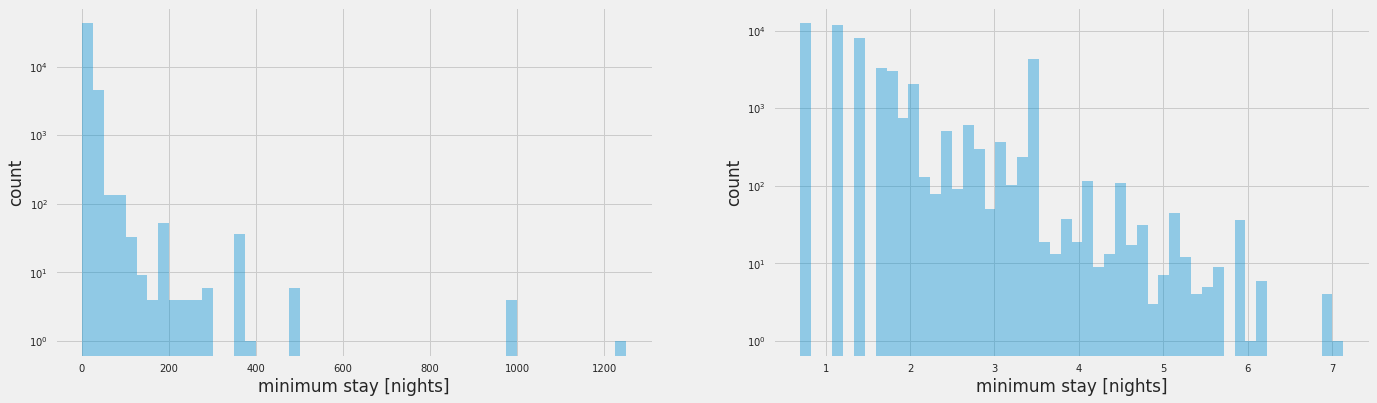

In [14]:
fig, axes = plt.subplots(1,2, figsize = (21,6))
sns.distplot(df['minimum_nights'],kde = False, ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(df['minimum_nights']), kde = False, ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [15]:
df['minimum_nights'] = np.log1p(df['minimum_nights'])

Trying to find the relationship between number_of_reviews and  availability_365.

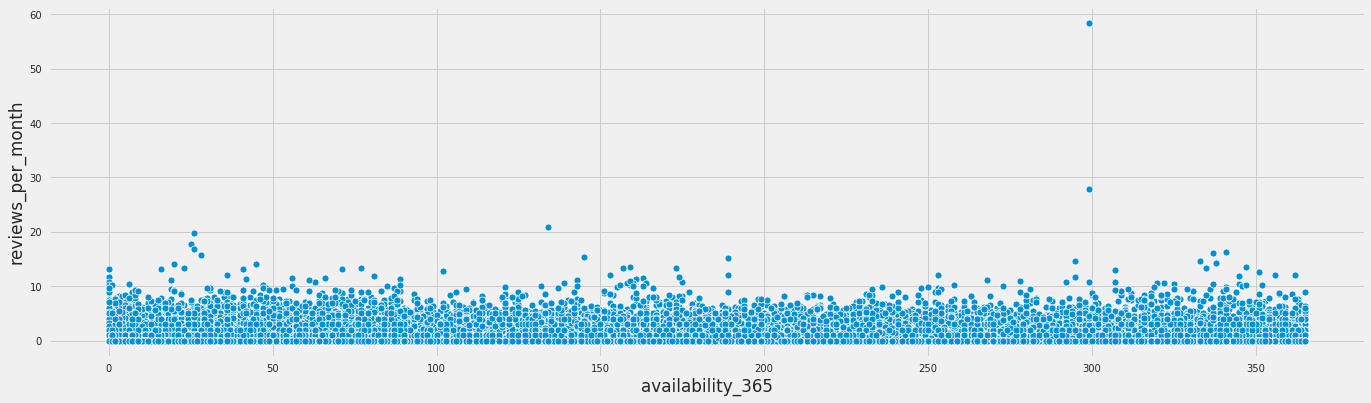

In [16]:
fig , axes = plt.subplots(1,1, figsize = (21,6))
sns.scatterplot(x = df['availability_365'], y = df['reviews_per_month'])

In [17]:
df['reviews_per_month'] = df[df['reviews_per_month'] < 15]['reviews_per_month']

In [18]:
df['reviews_per_month'].fillna(0, inplace = True)

In [19]:
cat_feat = df.select_dtypes(include = ['object'])
cat_feat_one_hot = pd.get_dummies(cat_feat)

In [20]:
cat_feat_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
num_feat = df.select_dtypes(exclude = ['object'])
y = num_feat.price
num_feat = num_feat.drop(['price'], axis = 1)

In [22]:
y_df = pd.DataFrame(y)

In [23]:
X = np.concatenate((num_feat, cat_feat_one_hot), axis = 1)
X_df = pd.concat([num_feat, cat_feat_one_hot], axis = 1)

In [24]:
data = pd.concat([X_df, y], axis = 1)
data.to_csv('NYC_airbnb_preprocessed.dat')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 50)

In [26]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [27]:
y_train.shape

(36459,)

In [28]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

rmse_rf=[]
rf=RandomForestRegressor(n_estimators = 100, random_state=1,  min_samples_leaf=2)
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(rf ,X_train, y_train, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_rf.append(avg_rmse)
print(rmse_rf)

rf.fit(X_train, y_train)

mse = mean_squared_error(y_test, rf.predict(X_test))
rmse = np.sqrt(np.absolute(mse))
rmse_rf.append(rmse)
print(rmse_rf)

Upon testing various regression algoritm, RandomForest had the least rmse score on training and test set.
So we will optimize RandomForest now.... 

from pprint import pprint
pprint(rf.get_params())

n_estimators = [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

pprint(random_grid)

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

rf_random.best_params_

param_grid = {'n_estimators': 78,
               'max_features': 'auto',
               'max_depth': None,
               'min_samples_split': 10,
               'min_samples_leaf': 2,
               'bootstrap': True}

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)


mae = mean_absolute_error(y_test, base_model.predict(X_test))
mape = 100*mae
acc = 100 - mape
print(acc)    

best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)
mae = mean_absolute_error(y_test, best_random.predict(X_test))
mape = 100*mae
acc = 100 - mape
print(acc)    

param_grid = {'n_estimators': [70, 80, 90, 100],
              'max_features': [2, 3],
               'min_samples_split': [9, 10, 11],
               'min_samples_leaf': [2],
               'bootstrap': ['True']}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
mae = mean_absolute_error(y_test, best_grid.predict(X_test))
mape = 100*mae
acc = 100 - mape
print(acc)


{'n_estimators': 78,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [29]:
best_rf = RandomForestRegressor(n_estimators = 80, min_samples_split = 10, max_features = 'auto', max_depth = None, bootstrap = True)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, best_rf.predict(X_test))
mape = 100*mae
acc = 100 - mape
print(acc)

70.09371062455747


In [30]:
print(r2_score(y_test,y_pred))

0.6265635932860811


In [31]:
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.4011018464184397
